# k-nearest neighbors

Classification of beans in species using k-nearest neighbors vote based on most important features according to the info provided by the optimal random forest.

In [1]:
# Installing dependencies
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

/tmp/ipykernel_34500/2937571346.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Fetching dataset and optimal random forest
with open('dry_bean_dataset.pkl', 'rb') as file:
    dry_bean_dataset = pickle.load(file)
with open('best_rf_clf.pkl', 'rb') as file:
    best_rf_clf = pickle.load(file)

In [3]:
# Sorting features by importance provided by the optimal random forest
features_dict = dict(enumerate(best_rf_clf.feature_importances_))
features_list = sorted(features_dict.items(), key = lambda item: item[1], reverse = True)
features_list

[(12, 0.13230804437680288),
 (3, 0.118051185681012),
 (1, 0.10762157150574396),
 (2, 0.08278332803380323),
 (14, 0.08275502212997302),
 (6, 0.08165018790808792),
 (11, 0.07042410808450564),
 (0, 0.054619880158169064),
 (7, 0.05132170914854989),
 (10, 0.04605925332177904),
 (4, 0.04584008675080864),
 (5, 0.04579069570237461),
 (13, 0.03730649937784407),
 (15, 0.02338449756405622),
 (9, 0.014191831163927436),
 (8, 0.005892099092562411)]

In [4]:
# Splitting dataset in training (70%) and test (30%) subsets
X_train, X_test, y_train, y_test = train_test_split(dry_bean_dataset.data.features, dry_bean_dataset.data.targets, test_size=0.3, random_state=42)
y_train = np.ravel(y_train)

In [5]:
# Defining the hyperparameter distribution for random search
param_dict = {
    'n_neighbors': randint(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']}

In [6]:
# Setting the random search

knn_clf = KNeighborsClassifier()
random_search = RandomizedSearchCV(knn_clf, param_distributions=param_dict, n_iter=100, cv=5, scoring='f1_weighted', random_state=42, n_jobs = -1)
features_train = []
results_df1 = pd.DataFrame(columns = ['metric', 'n_neighbors', 'weights'])
results_df2 = pd.DataFrame(columns = ['Precision', 'Recall', 'F1 score', 'Accuracy', 'Feature added'])

for feature_index, feature_importance in features_list: # Feeding new features by importance in each interation
    
    # Optimizing the hyperparameters
    features_train.append(feature_index)
    X_train_temp = X_train.iloc[:,features_train]
    random_search.fit(X_train_temp, y_train)
    results_df1.loc[len(features_train)] = random_search.best_params_

    # Evaluating the model
    best_clf = random_search.best_estimator_
    y_pred = best_clf.predict(X_test.iloc[:,features_train])
    precision = round(precision_score(y_test, y_pred, average='weighted'), 4)
    recall = round(recall_score(y_test, y_pred, average='weighted'), 4)
    f1 = round(f1_score(y_test, y_pred, average='weighted'), 4)
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    feature = dry_bean_dataset.data.features.columns[feature_index]
    results_df2.loc[len(features_train)] = [precision, recall, f1, accuracy, feature]

results_df = pd.concat([results_df1, results_df2], axis = 1)
results_df

,metric,n_neighbors,weights,Precision,Recall,F1 score,Accuracy,Feature added
1,euclidean,19,uniform,0.5464,0.5715,0.5477,0.5715,ShapeFactor1
2,euclidean,18,uniform,0.5354,0.5636,0.5411,0.5636,MinorAxisLength
3,minkowski,12,uniform,0.8411,0.8425,0.8412,0.8425,Perimeter
4,minkowski,9,distance,0.9059,0.9050,0.9052,0.9050,MajorAxisLength
5,minkowski,9,distance,0.9059,0.9050,0.9052,0.9050,ShapeFactor3
6,manhattan,4,distance,0.8454,0.8417,0.8403,0.8417,ConvexArea
7,manhattan,4,distance,0.8454,0.8417,0.8403,0.8417,Compactness
8,manhattan,5,distance,0.7883,0.7869,0.7855,0.7869,Area
9,manhattan,5,distance,0.7882,0.7869,0.7855,0.7869,EquivDiameter
10,manhattan,5,distance,0.7882,0.7869,0.7855,0.7869,Roundness


Without doubt, best hyperparameters are {'n_neighbors': 9, 'weights': 'distance', 'metric': 'minkowski'}. Additionally, analyzing the features in depth, metric scores get the highest values when using just the first four most important features: ShapeFactor1, MinorAxisLength, Perimeter, MajorAxisLength. Last three have feature correlation values over 0.8 between them; correlated features may contain complementary that capture different aspects of the underlying data distribution. On the other hand, metrics remain invariant when 'ShapeFactor3' is added, which has feature correlation values under 0.0 with first four features, so it is non redundant, but non informative. Now, notice that when adding 'MinorAxisLength', metrics worse momentarily, so is the model performance changing when eliminating either 'ShapeFactor1' or 'MinorAxisLength'?

In [24]:
# Evaluating the model performance when eliminating either 'ShapeFactor1' or 'MinorAxisLength'?
results_df1 = pd.DataFrame(columns = ['metric', 'n_neighbors', 'weights'])
results_df2 = pd.DataFrame(columns = ['Precision', 'Recall', 'F1 score', 'Accuracy', 'Feature eliminated'])
feature_eliminated = ['MinorAxisLength', 'ShapeFactor1']

for i, j in enumerate([['ShapeFactor1', 'Perimeter', 'MajorAxisLength'], ['MinorAxisLength', 'Perimeter', 'MajorAxisLength']]):
    
    # Optimizing the hyperparameters
    X_train_temp = X_train.loc[:,j]
    random_search.fit(X_train_temp, y_train)
    results_df1.loc[i] = random_search.best_params_

    # Evaluating the model
    best_clf = random_search.best_estimator_
    y_pred = best_clf.predict(X_test.loc[:,j])
    precision = round(precision_score(y_test, y_pred, average='weighted'), 4)
    recall = round(recall_score(y_test, y_pred, average='weighted'), 4)
    f1 = round(f1_score(y_test, y_pred, average='weighted'), 4)
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    feature = feature_eliminated[i]
    results_df2.loc[i] = [precision, recall, f1, accuracy, feature]

results_df = pd.concat([results_df1, results_df2], axis = 1)
results_df

,metric,n_neighbors,weights,Precision,Recall,F1 score,Accuracy,Feature eliminated
0,manhattan,16,uniform,0.8837,0.8826,0.8826,0.8826,MinorAxisLength
1,minkowski,9,distance,0.9059,0.9050,0.9052,0.9050,ShapeFactor1


Removing the most important feature does not compromise the predictive scores while enhancing the computational efficiency. The model is robust.

In [25]:
# Training the optimal k-neighbors classifier
knn_clf = KNeighborsClassifier(n_neighbors = 9, weights = 'distance', metric = 'minkowski')
X_train_temp = X_train.loc[:,['MinorAxisLength', 'Perimeter', 'MajorAxisLength']]
knn_clf.fit(X_train_temp, y_train)
results_df.loc[1]

metric                   minkowski
n_neighbors                      9
weights                   distance
Precision                   0.9059
Recall                       0.905
F1 score                    0.9052
Accuracy                     0.905
Feature eliminated    ShapeFactor1
Name: 1, dtype: object

In [26]:
# Evaluating the model by classes
X_test_temp = X_test.loc[:,['MinorAxisLength', 'Perimeter', 'MajorAxisLength']]
y_pred = knn_clf.predict(X_test_temp)
results_df_class = pd.DataFrame(columns = sorted(set(y_test['Class'])))
results_df_class.loc['Precision'] = np.around(precision_score(y_test, y_pred, average=None), decimals = 4)
results_df_class.loc['Recall'] = np.around(recall_score(y_test, y_pred, average=None), decimals = 4)
results_df_class.loc['F1 score'] = np.around(f1_score(y_test, y_pred, average=None), decimals = 4)
results_df_class

,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Precision,0.9208,1.0,0.8898,0.9001,0.9590,0.9370,0.8360
Recall,0.8510,1.0,0.9387,0.9136,0.9295,0.9142,0.8570
F1 score,0.8845,1.0,0.9136,0.9068,0.9440,0.9255,0.8463


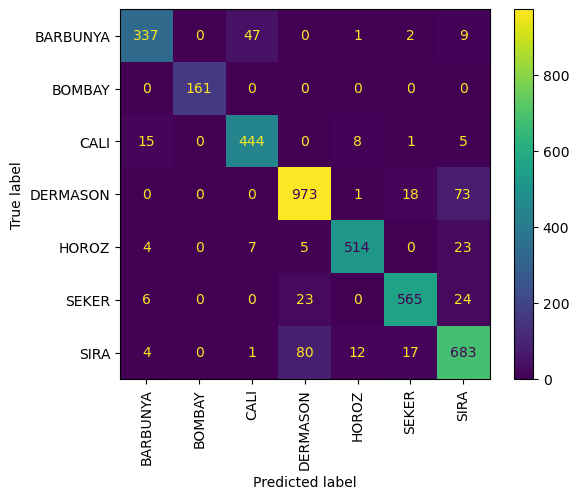

In [27]:
# Plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = sorted(set(y_test['Class'])))
disp.plot()
plt.xticks(rotation=90)
plt.show()

In [28]:
# Saving optimal k-neighbors classifier
with open('best_knn_clf.pkl', 'wb') as file:
    pickle.dump(knn_clf, file)